<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_auto_ml_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [0]:
COLAB = True

In [3]:
if COLAB:
  !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (885 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-prec

In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [8]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [9]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/"feature_matrix.csv"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/'4D.zip'

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 1151M
-rw------- 1 root root 407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root 428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root 141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 176M Dec 27 08:28 feature_matrix.pkl
total 1M
-rw-r--r-- 1 root root 1M Dec 31 08:10 4D.txt
-rw-r--r-- 1 root root 1M Dec 31 08:10 4D.zip


In [0]:
data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
origin_data = format_tabular(ORIGIN_DATASET)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699972 entries, 0 to 699971
Data columns (total 53 columns):
NumberId                                   699972 non-null int64
time                                       699972 non-null datetime64[ns]
SUM(Results.DrawNo)                        699972 non-null int64
SUM(Results.LuckyNo)                       699972 non-null int64
SUM(Results.TotalStrike)                   699972 non-null int64
STD(Results.DrawNo)                        699575 non-null float64
STD(Results.LuckyNo)                       699575 non-null float64
STD(Results.TotalStrike)                   699575 non-null float64
MAX(Results.DrawNo)                        699972 non-null int64
MAX(Results.LuckyNo)                       699972 non-null int64
MAX(Results.TotalStrike)                   699972 non-null int64
SKEW(Results.DrawNo)                       696365 non-null float64
SKEW(Results.LuckyNo)                      696365 non-null float64
SKEW(Results.TotalStrike)

## Preliminary Modeling

In [0]:
feature_matrix = data

In [14]:
feature_matrix.columns

Index(['NumberId', 'time', 'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'SKEW(Results.DrawNo)',
       'SKEW(Results.LuckyNo)', 'SKEW(Results.TotalStrike)',
       'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       'MIN(Results.TotalStrike)', 'MEAN(Results.DrawNo)',
       'MEAN(Results.LuckyNo)', 'MEAN(Results.TotalStrike)', 'COUNT(Results)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'YEAR(first_Results_time)', 'MONTH(first_Results_time)',
       'WEEKDAY(first_Results_time)', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Res

In [15]:
feature_matrix.head(4).T

,0,1,2,3
NumberId,0,1,2,3
time,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00
SUM(Results.DrawNo),1857929,1571202,898913,1628516
SUM(Results.LuckyNo),0,9,8,24
SUM(Results.TotalStrike),8,9,4,8
STD(Results.DrawNo),116257,96697.5,49525.7,116135
STD(Results.LuckyNo),0,0,0,0
STD(Results.TotalStrike),0,0,0,0
MAX(Results.DrawNo),394013,363311,265606,393913
MAX(Results.LuckyNo),0,1,2,3


In [16]:
origin_data[origin_data['LuckyNo']==0].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
11686,91595,1995-08-02,3rdPrizeNo,0
21541,134398,1998-04-26,SpecialNo1,0
23100,141198,1998-10-01,ConsolationNo5,0
30430,173000,2000-09-09,2ndPrizeNo,0
48346,251005,2005-06-04,1stPrizeNo,0
56190,285107,2007-06-06,2ndPrizeNo,0
79783,387613,2013-05-04,SpecialNo6,0
81258,394013,2013-09-14,SpecialNo9,0
82908,401214,2014-02-08,SpecialNo3,0
85712,413414,2014-10-18,SpecialNo10,0


Text(0, 0.5, 'Strike Per Number')

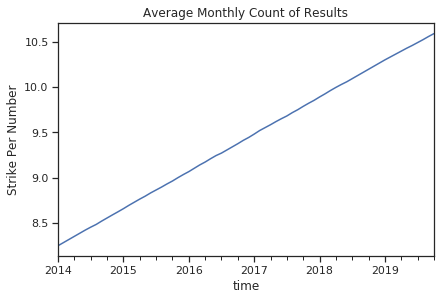

In [17]:
feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
plt.title('Average Monthly Count of Results')
plt.ylabel('Strike Per Number')

## Feature Selection

In [18]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (699972, 51)
0 missing columns with threshold: 90.
7 zero variance columns.
5 collinear columns removed with threshold: 0.95.
Total columns removed:  12
Shape after feature selection: (699972, 39).


In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [21]:
feature_matrix_selection.columns

Index(['SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)', 'SKEW(Results.DrawNo)',
       'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'MONTH(first_Results_time)', 'WEEKDAY(first_Results_time)',
       'TotalStrike', 'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Results.PrizeType)_ConsolationNo2',
       'MODE(Results.PrizeType)_ConsolationNo3',
       'MODE(Results.PrizeType)_ConsolationNo4',
       'MODE(Results.PrizeType)_ConsolationNo5',
       'MODE(Results.PrizeType)_ConsolationNo6',
       'MODE(Results.PrizeType)_ConsolationNo7',
       'MODE(Results.PrizeType)_ConsolationNo8',
       'MODE(Results.PrizeType

## Correlations

In [22]:
feature_matrix_selection.shape

(699972, 42)

In [23]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

MODE(Results.PrizeType)_SpecialNo8       -0.003139
MODE(Results.PrizeType)_ConsolationNo9   -0.002791
year                                     -0.002787
MAX(Results.LuckyNo)                     -0.002340
NumberId                                 -0.002340
Name: TotalStrike, dtype: float64

In [25]:
corrs['Label'].dropna().tail()

MAX(Results.DrawNo)     0.003222
MEAN(Results.DrawNo)    0.003457
SUM(Results.DrawNo)     0.003557
Label                   1.000000
TotalStrike             0.991613
Name: Label, dtype: float64

In [26]:
corrs['TotalStrike'].dropna().tail()

MAX(Results.DrawNo)     0.003362
MEAN(Results.DrawNo)    0.003483
SUM(Results.DrawNo)     0.003516
Label                   0.991613
TotalStrike             1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [28]:
!pip install autoviz

In [29]:
from autoviz.AutoViz_Class import AutoViz_Class

Imported AutoViz_Class version: 0.0.67. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


### XgBoost

In [0]:
import xgboost as xgb

In [0]:
model = xgb.XGBClassifier?

In [0]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year'])
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year'])
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   

    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    
    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [0]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

In [0]:
june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix_selection)

In [0]:
from utils import plot_feature_importances

norm_june_fi = plot_feature_importances(june_2019)

## Comparison to Baseline